In [60]:
# Python file -beginning stage
# Initial set up and read in data from spreadsheet. Will need cleaning and intial data wrangle and assessment and EDA. 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in the CSV -- NOT YET USED 
df = pd.read_csv(r"C:\Users\adam_\Desktop\2. Udacity - Data Science\PROJECTS\BLOG_POST_NEW\DAta\GDP_Dependent.csv")

df.head(4)


,Country Name,Country Code,GDP INCREASING 1.5%,Population Growth,Life Expectancy,Fertility Rate,Mortality Rate,Inflation,Goods Imported,Gross capital formation,"Revenue, non grant",Military Expenditure,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,Afghanistan,AFG,0,2.41,62.75,4.70,60.63,5.74,44.59,14.10,#DIV/0!,1.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,1,-0.86,77.39,1.40,9.43,4.08,43.44,26.02,24.53,1.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZA,1,1.65,76.11,2.91,22.63,7.18,22.96,39.91,#DIV/0!,5.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Angola,AGO,1,3.21,62.07,5.33,70.43,20.02,24.57,24.14,21.79,1.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** Recall project aim: to see how accurately this data can predict an increase in GDP over the 5 year period - we define "increase" as raising 1.5% per year for at least 3 years. 

## FUNCTIONS WILL BE DEFINED AND SAVED UP TOP, TO BE CALLED THROUGHOUT. HERE IS A LIST OF FUNCTIONS

1. remove_unnamed_columns(df) - 
2. check_missing_values(df) - check in place
3. count_missing_values_per_row(df_cleaned)
4. impute_missing_values
5. 
6. 

In [61]:
# DATA CLEANING 
## Remove these unnamed columns that should not have been bought over. 

#Use function
def remove_unnamed_columns(df):
    """
    Removes columns with names starting with "Unnamed" from a pandas DataFrame.

    Args:
        df: The pandas DataFrame to clean.

    Returns:
        A new pandas DataFrame with the "Unnamed" columns removed.
    """
    unnamed_cols = [col for col in df.columns if 'Unnamed:' in col]
    df = df.drop(columns=unnamed_cols, errors='ignore') 
    return df


In [62]:
# define function to check for any missing values 
def check_missing_values(df_cleaned):
    """
    Checks for missing values in our DataFrame and prints a summary.

    Args:
        df: The pandas DataFrame.
    """
    missing_values = df_cleaned.isnull().sum()
    total_missing = missing_values.sum()

    if total_missing == 0:
        print("No missing values found in the DataFrame.")
    else:
        print("Missing Values Summary:")
        print(missing_values)
        print(f"\nTotal missing values: {total_missing}")

In [ ]:
# Calculate the missing values per country in new column 
#Create function
def count_missing_values_per_row(df_cleaned):
    """
    Counts missing values (NaN, None, or '#DIV/0!') in each row of a DataFrame
    and adds the count to a new column named 'Missing Values Count'.

    Args:
        df_cleaned: The pandas DataFrame.

    Returns:
        The DataFrame with the new 'Missing Values Count' column.
    """

    # Replace '#DIV/0!' with NaN for consistent missing value handling
    df_cleaned = df_cleaned.replace('#DIV/0!', np.nan)

    # Count the number of missing values in each row
    df_cleaned['Missing Values Count'] = df_cleaned.isnull().sum(axis=1)

    return df_cleaned

In [ ]:
# function to remove the rows with 4 or more missing values 
def remove_rows_with_many_missing(df_cleaned, threshold=4):
    """
    Removes rows from a DataFrame where the 'Missing Values Count' is greater than or equal to a given threshold.

    Args:
        df_cleaned: The pandas DataFrame with the 'Missing Values Count' column.
        threshold: The minimum number of missing values for a row to be removed.

    Returns:
        The DataFrame with the rows removed.
    """
    df_filtered = df_cleaned[df_cleaned['Missing Values Count'] < threshold]
    return df_filtered

In [ ]:
# Impute any remaining missing values, using mean values and sklearn
from sklearn.impute import SimpleImputer

#define function for umputation
def impute_missing_values(df_cleaned, strategy='mean'):
    """
    Imputes missing values in a DataFrame using a specified strategy.

    Args:
        df_cleaned: The updated pandas DataFrame.
        strategy: The imputation strategy ('mean', 'median', or 'most_frequent').

    Returns:
        The DataFrame with imputed missing values.
    """

    # Create an imputer object
    imputer = SimpleImputer(strategy=strategy)

    # Identify numerical columns for imputation
    numerical_cols = df_cleaned.select_dtypes(include=np.number).columns

    # Impute missing values in numerical columns
    df_cleaned[numerical_cols] = imputer.fit_transform(df_cleaned[numerical_cols])

    return df

### ^^^^^^ FUNCTIONS ARE ALL SAVED ABOVE ^^^^^ ### 

### CODE STARTS BELOW 

In [65]:
# Firstly, remove the numamed columns that were bought over from import
df_cleaned = remove_unnamed_columns(df)

print(df_cleaned.head()) # looks ok 

          Country Name Country Code  GDP INCREASING 1.5%  Population Growth  \
0          Afghanistan          AFG                    0               2.41   
1              Albania          ALB                    1              -0.86   
2              Algeria          DZA                    1               1.65   
3               Angola          AGO                    1               3.21   
4  Antigua and Barbuda          ATG                    1               0.52   

  Life Expectancy Fertility Rate Mortality Rate  Inflation Goods Imported  \
0           62.75           4.70          60.63       5.74          44.59   
1           77.39           1.40           9.43       4.08          43.44   
2           76.11           2.91          22.63       7.18          22.96   
3           62.07           5.33          70.43      20.02          24.57   
4           78.82           1.55           9.88       3.55          59.48   

  Gross capital formation Revenue, non grant Military Expendit

FIX THE ISSUES OF THE NUMEROUS #DIV/0! THROUGHOUT. 
We have 9 independent variables in this data set and will need some level of imputation. Would be acceptable to impute 3 of these per country so will first text how many missing values each country has. 

If the country has 4 or more missing values these rows will be deleted. 

In [ ]:
# call the function onto our data and view - we have 174 rows ATM 
df_missing = count_missing_values_per_row(df_cleaned)

print(df_missing.head(5))

          Country Name Country Code  GDP INCREASING 1.5%  Population Growth  \
0          Afghanistan          AFG                    0               2.41   
1              Albania          ALB                    1              -0.86   
2              Algeria          DZA                    1               1.65   
3               Angola          AGO                    1               3.21   
4  Antigua and Barbuda          ATG                    1               0.52   

  Life Expectancy Fertility Rate Mortality Rate  Inflation Goods Imported  \
0           62.75           4.70          60.63       5.74          44.59   
1           77.39           1.40           9.43       4.08          43.44   
2           76.11           2.91          22.63       7.18          22.96   
3           62.07           5.33          70.43      20.02          24.57   
4           78.82           1.55           9.88       3.55          59.48   

  Gross capital formation Revenue, non grant Military Expendit

In [72]:
# Remove rows with 4 or more missing values
df_cleaned = remove_rows_with_many_missing(df_missing)

# Print the resulting DataFrame - we are down to 160 rows in this data set. We now have 160 rows 
print(df_cleaned)

            Country Name Country Code  GDP INCREASING 1.5%  Population Growth  \
0            Afghanistan          AFG                    0               2.41   
1                Albania          ALB                    1              -0.86   
2                Algeria          DZA                    1               1.65   
3                 Angola          AGO                    1               3.21   
4    Antigua and Barbuda          ATG                    1               0.52   
..                   ...          ...                  ...                ...   
169              Uruguay          URY                    1              -0.04   
170           Uzbekistan          UZB                    1               1.93   
171             Viet Nam          VNM                    1               0.84   
172   West Bank and Gaza          PSE                    1               2.45   
173               Zambia          ZMB                    1               2.85   

    Life Expectancy Fertili

In [73]:
#Check for missing values

check_missing_values(df_cleaned)

Missing Values Summary:
Country Name                0
Country Code                0
GDP INCREASING 1.5%         0
Population Growth           0
Life Expectancy             1
Fertility Rate              0
Mortality Rate              5
Inflation                   0
Goods Imported              9
Gross capital formation    12
Revenue, non grant         34
Military Expenditure       27
Missing Values Count        0
dtype: int64

Total missing values: 88


In [ ]:
# View with imputed values and then check
df_final = impute_missing_values(df_cleaned, strategy='mean') 

C:\Users\adam_\AppData\Local\Temp/ipykernel_93620/1416653012.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned[numerical_cols] = imputer.fit_transform(df_cleaned[numerical_cols])


In [76]:
check_missing_values(df_final)

Missing Values Summary:
Country Name                 0
Country Code                 0
GDP INCREASING 1.5%          0
Population Growth            0
Life Expectancy              0
Fertility Rate               0
Mortality Rate               0
Inflation                    0
Goods Imported               0
Gross capital formation      0
Revenue, non grant           0
Military Expenditure         0
Unnamed: 12                174
Unnamed: 13                174
Unnamed: 14                174
Unnamed: 15                174
Unnamed: 16                174
Unnamed: 17                174
Unnamed: 18                174
dtype: int64

Total missing values: 1218


Data now looks clean, however somehow the unnamed colums are back - re-run that function on the df_final dataset then retest

In [80]:
df_ml = remove_unnamed_columns(df_final)


In [81]:
check_missing_values(df_ml)

No missing values found in the DataFrame.


SECTION 2 - some EDA before proceeding to build the model. 

In [87]:
# First ensure all values in DF are as floats 
df_ml = df_ml.apply(pd.to_numeric, errors='coerce').astype(float)

print(df_ml.dtypes)

Country Name               float64
Country Code               float64
GDP INCREASING 1.5%        float64
Population Growth          float64
Life Expectancy            float64
Fertility Rate             float64
Mortality Rate             float64
Inflation                  float64
Goods Imported             float64
Gross capital formation    float64
Revenue, non grant         float64
Military Expenditure       float64
dtype: object


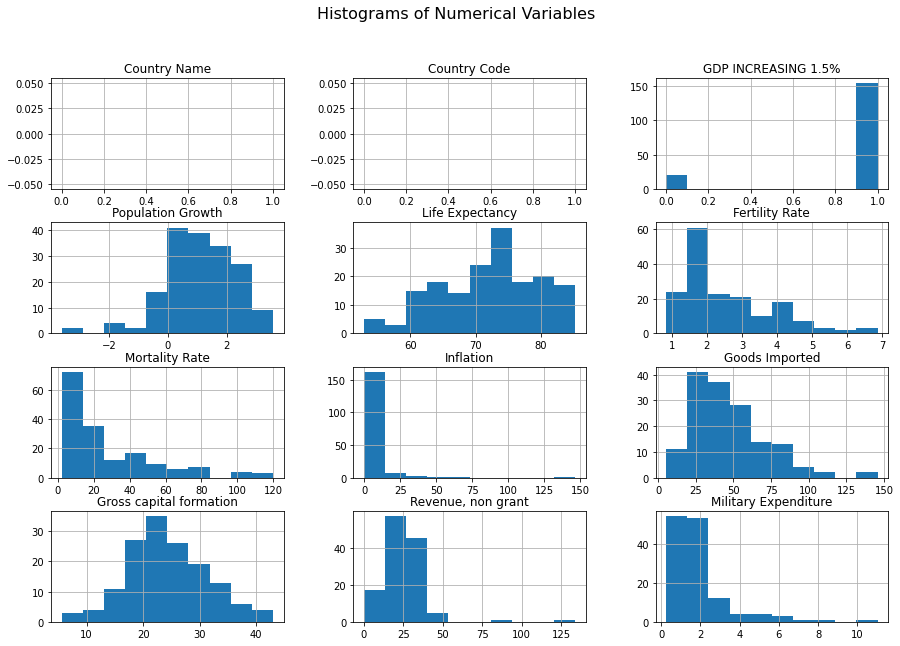

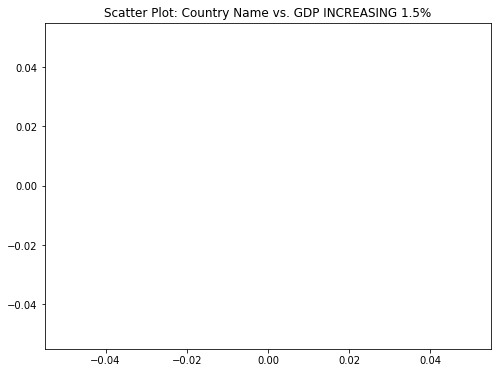

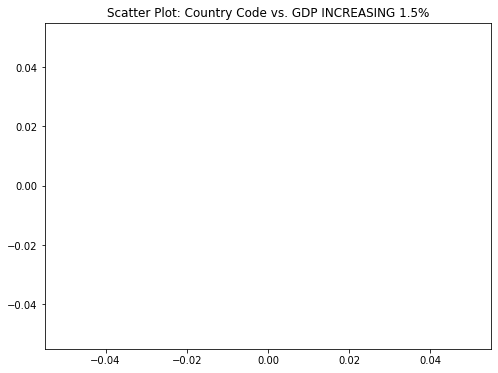

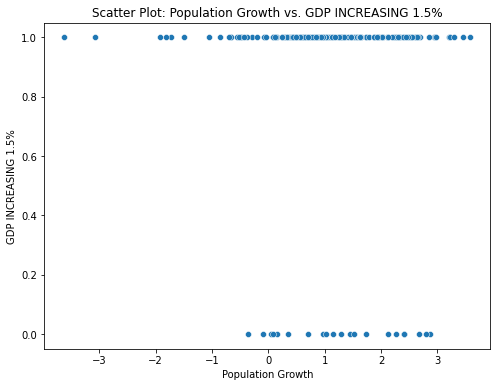

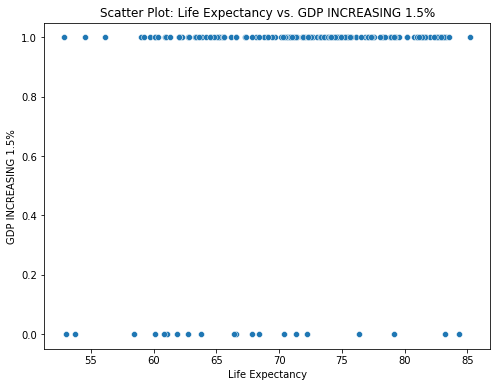

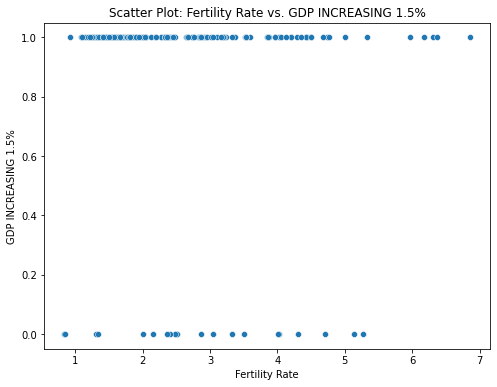

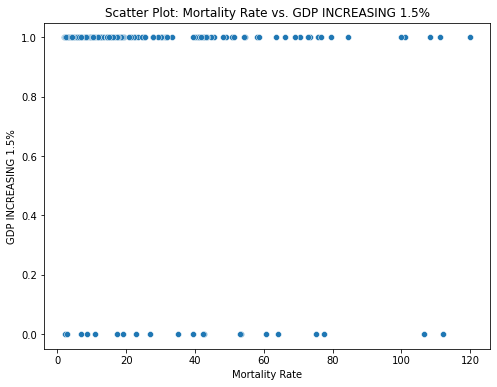

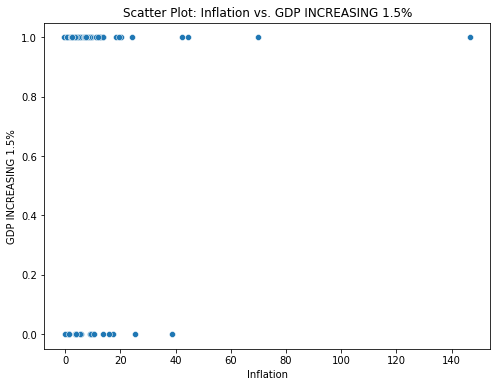

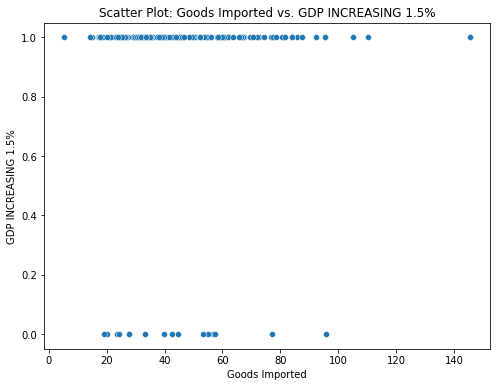

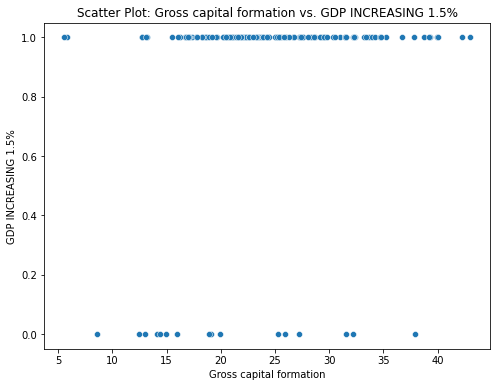

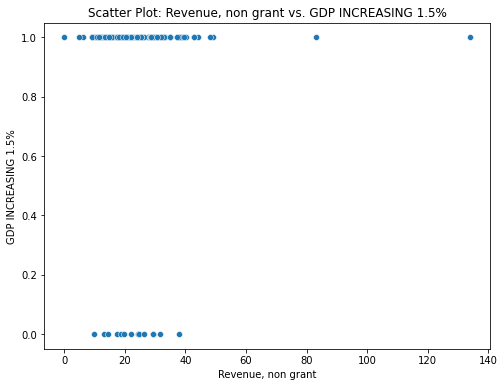

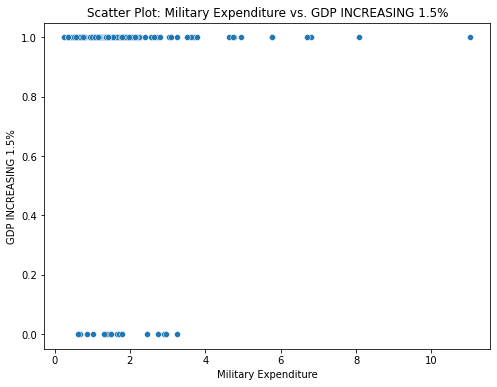

In [ ]:
# Write a funciton to include some of the intial visuals 
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_eda(df_ml, dependent_variable):
    """
    Performs EDA visualizations on a DataFrame.

    Args:
        df_ml: The final DataFrame.
        dependent_variable: GDP Column
    """

    # 1. Histograms
    df.hist(figsize=(15, 10))
    plt.suptitle("Histograms of Numerical Variables", fontsize=16)
    plt.show()



    # 2. Scatter Plots
    numerical_cols = df.select_dtypes(include=['float']).columns.tolist()
    numerical_cols.remove(dependent_variable)  # Remove dependent variable from independent variable list.

    for col in numerical_cols:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=col, y=dependent_variable, data=df)
        plt.title(f"Scatter Plot: {col} vs. {dependent_variable}")
        plt.show()

    # Pairwise scatter plots of independent variables
    sns.pairplot(df[numerical_cols])
    plt.suptitle("Pairwise Scatter Plots of Independent Variables", fontsize=16)
    plt.show()

    # 3. Box Plots
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=df[numerical_cols])
    plt.title("Box Plots of Numerical Variables")
    plt.xticks(rotation=45)
    plt.show()

# Load the df_ml
df = df_ml

# Dependend variable dec 
dependent_variable_name = "GDP INCREASING 1.5%"

# Run the EDA visualizations
visualize_eda(df, dependent_variable_name)